In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from random import sample, choice
from glob import glob

# import cv2
from PIL import Image

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from skimage.feature import hog
from skimage.color import rgb2gray


In [8]:
# Get image data

root_path = "./Intel Training Dataset/"

# split into subfolders based on class label
subfolders = sorted(glob(root_path + "*"))
label_names = [p.split("/")[-1] for p in subfolders]

data = {
    "image_labels": [],
    "image_filenames": [],
    "feature_vectors": [],
}

for i, subfolder in enumerate(subfolders):
    # get list of file paths for each subfolder
    file_paths = sorted(glob(subfolder + "/*.jpg"))
    for f in file_paths:
        # img = cv2.imread(f, 0)
        img_base = Image.open(f).resize((100,100))
        img_flipped = img_base.transpose(Image.TRANSPOSE)
        for img in (img_base, img_flipped):
            # maybe resize image with img = img.resize((100,100))
            feature_vector_1 = hog(
                img,
                orientations=10,
                pixels_per_cell=(15, 15),
                cells_per_block=(1, 1),
                block_norm="L2",
                channel_axis=-1,
            )
            feature_vector_2 = np.histogram(rgb2gray(img), bins=16, density=True)[0]
            feature_vector = np.hstack((feature_vector_1, feature_vector_2))
            data["feature_vectors"].append(feature_vector)
            data["image_filenames"].append(f)
            data["image_labels"].append(i)


In [9]:
# convert to dataframe for storage
df = pd.DataFrame(data=data)

# store it
df.to_pickle("feature_backup.pkl")


In [10]:
df = pd.read_pickle("feature_backup.pkl")

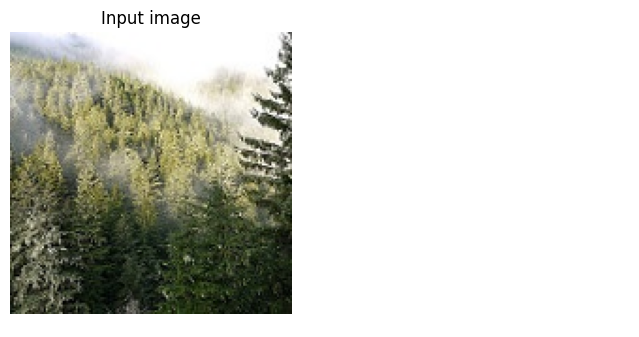

feature vector size: (376,)


In [11]:
random_ix = choice(range(len(df["image_filenames"])))
img = Image.open(df["image_filenames"][random_ix])
# hog_img = df["hog_images"][random_ix]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis("off")
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title("Input image")

ax2.axis("off")
# ax2.imshow(hog_image, cmap=plt.cm.gray)
# ax2.set_title("Histogram of Oriented Gradients")
plt.show()

print("feature vector size:", df["feature_vectors"][random_ix].shape)


In [12]:
# train/validation split
feature_vectors = np.vstack(df["feature_vectors"])
labels = df["image_labels"]

X_train, X_test, y_train, y_test = train_test_split(
    feature_vectors, labels, test_size=0.2, stratify=labels, random_state=0
)
print(X_train.shape, y_train.shape)

(15712, 376) (15712,)


In [13]:
# train one model

clf = make_pipeline(StandardScaler(), SVC(gamma='scale', kernel="rbf", C=0.5))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

Overall train accuracy:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      2453
           1       0.95      0.96      0.96      2542
           2       0.86      0.86      0.86      2691
           3       0.87      0.85      0.86      2813
           4       0.86      0.87      0.86      2546
           5       0.94      0.94      0.94      2667

    accuracy                           0.90     15712
   macro avg       0.90      0.90      0.90     15712
weighted avg       0.90      0.90      0.90     15712

Overall test accuracy:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       613
           1       0.89      0.93      0.91       636
           2       0.62      0.68      0.65       673
           3       0.63      0.60      0.61       703
           4       0.70      0.66      0.68       636
           5       0.83      0.84      0.83       667

    accuracy                  

<Axes: >

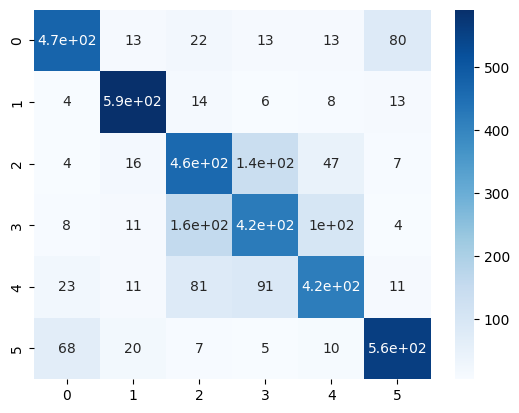

In [14]:
# report accuracy

train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)
print(f"Overall train accuracy:")
print(classification_report(y_train, train_pred))
print(f"Overall test accuracy:")
print(classification_report(y_test, test_pred))

C = confusion_matrix(y_test, test_pred)
sn.heatmap(C, annot=True, cmap="Blues")

In [15]:
# train model w/ gridsearch

parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 0.5, 1, 2, 5], 'gamma': ("scale", "auto")}
svc = SVC()
clf = GridSearchCV(svc, parameters, verbose=2)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=  35.8s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=  35.2s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=  37.1s
[CV] END .................C=0.01, gamma=scale, kernel=linear; total time=  37.7s


KeyboardInterrupt: 

In [ ]:
print(sorted(clf.cv_results_.items()))

kernels_tested = parameters["kernel"]
C_tested = parameters["C"]


n_kernels = len(kernels_tested)
bar_x = np.arange(len(C_tested))
offset = 0.25

fig, ax = plt.subplots(layout='constrained')

for i,  kernel in enumerate(kernels_tested):
    result_data = clf.cv_results_["mean_test_score"][clf.cv_results_["param_kernel"] == kernel]
    plt.bar(bar_x + i * offset, result_data, offset, label=kernel)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('score')
ax.set_xticks(bar_x + offset, C_tested)
ax.set_xlabel("C")
ax.legend()

plt.show()